# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs175/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [89]:
import random
import numpy as np
from cs175.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [90]:
from cs175.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs175/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [91]:
from cs175.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [92]:
# Use the validation set to tune the learning rate and regularization strength

from cs175.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-6, 1e-7, 5e-7, 1e-8]
regularization_strengths = [4.5e4, 5e4, 5.5e4, 6e4]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for learn in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=learn, reg=reg, num_iters=2000)
        p_train = svm.predict(X_train_feats)
        p_val   = svm.predict(X_val_feats)

        train_acc = np.mean(p_train == y_train)
        val_acc   = np.mean(p_val == y_val)

        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

        results[(learn, reg)] = train_acc, val_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 4.500000e+04 train accuracy: 0.107694 val accuracy: 0.100000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.120816 val accuracy: 0.107000
lr 1.000000e-08 reg 5.500000e+04 train accuracy: 0.111776 val accuracy: 0.114000
lr 1.000000e-08 reg 6.000000e+04 train accuracy: 0.098898 val accuracy: 0.108000
lr 1.000000e-07 reg 4.500000e+04 train accuracy: 0.175102 val accuracy: 0.184000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.182429 val accuracy: 0.185000
lr 1.000000e-07 reg 5.500000e+04 train accuracy: 0.183388 val accuracy: 0.194000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 0.213163 val accuracy: 0.235000
lr 5.000000e-07 reg 4.500000e+04 train accuracy: 0.177653 val accuracy: 0.195000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.197041 val accuracy: 0.215000
lr 5.000000e-07 reg 5.500000e+04 train accuracy: 0.195347 val accuracy: 0.192000
lr 5.000000e-07 reg 6.000000e+04 train accuracy: 0.192653 val accuracy: 0.209000
lr 5.000000e-06 reg 4.500000

In [93]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.285


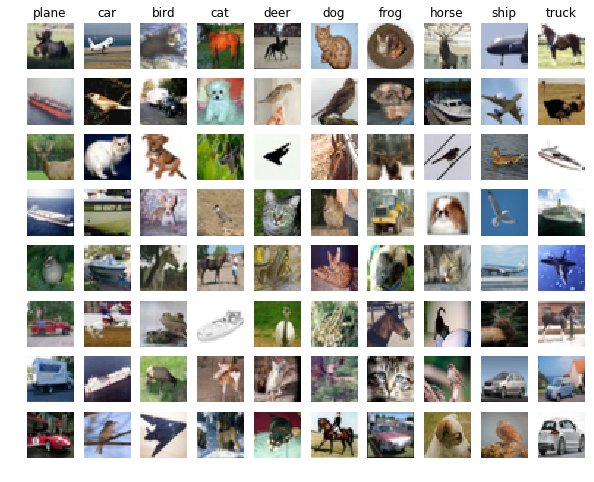

In [94]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [95]:
print(X_train_feats.shape)

(49000L, 155L)


hidden:  500
batch:  200
learning:  0.1
reg:  0.0005
iteration 0 / 1200: loss 2.302586
iteration 100 / 1200: loss 2.303600
iteration 200 / 1200: loss 2.053419
iteration 300 / 1200: loss 1.848397
iteration 400 / 1200: loss 1.681598
iteration 500 / 1200: loss 1.565326
iteration 600 / 1200: loss 1.426184
iteration 700 / 1200: loss 1.367890
iteration 800 / 1200: loss 1.583489
iteration 900 / 1200: loss 1.573623
iteration 1000 / 1200: loss 1.372810
iteration 1100 / 1200: loss 1.338747


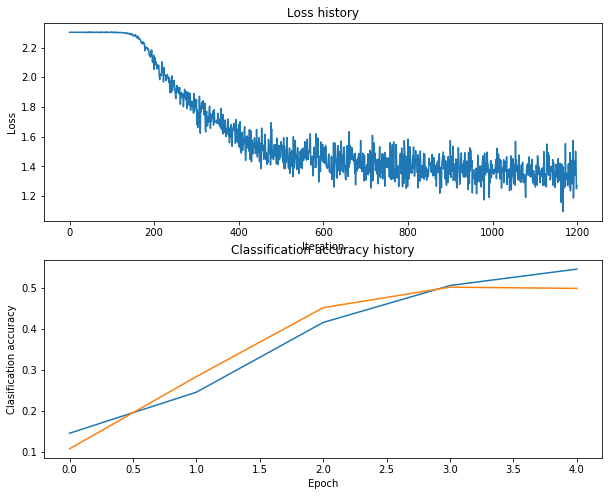

reg:  0.001
iteration 0 / 1200: loss 2.302586
iteration 100 / 1200: loss 2.301353
iteration 200 / 1200: loss 2.118878
iteration 300 / 1200: loss 1.715180
iteration 400 / 1200: loss 1.651171
iteration 500 / 1200: loss 1.477381
iteration 600 / 1200: loss 1.507628
iteration 700 / 1200: loss 1.424014
iteration 800 / 1200: loss 1.507432
iteration 900 / 1200: loss 1.325960
iteration 1000 / 1200: loss 1.380670
iteration 1100 / 1200: loss 1.429797


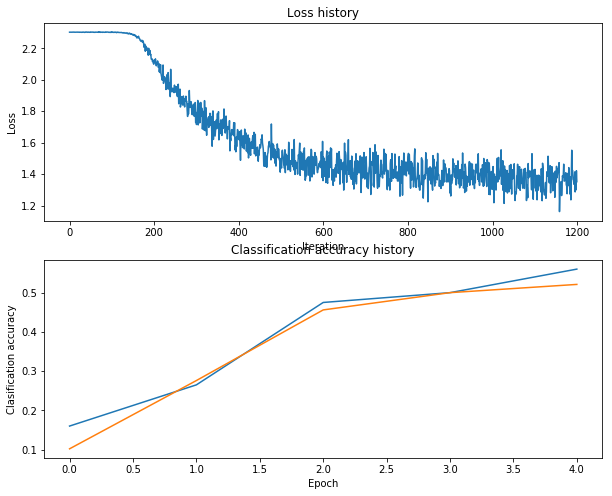

learning:  0.2
reg:  0.0005
iteration 0 / 1200: loss 2.302585
iteration 100 / 1200: loss 2.117439
iteration 200 / 1200: loss 1.610700
iteration 300 / 1200: loss 1.565562
iteration 400 / 1200: loss 1.314654
iteration 500 / 1200: loss 1.400723
iteration 600 / 1200: loss 1.335673
iteration 700 / 1200: loss 1.405001
iteration 800 / 1200: loss 1.384284
iteration 900 / 1200: loss 1.361855
iteration 1000 / 1200: loss 1.337030
iteration 1100 / 1200: loss 1.470556


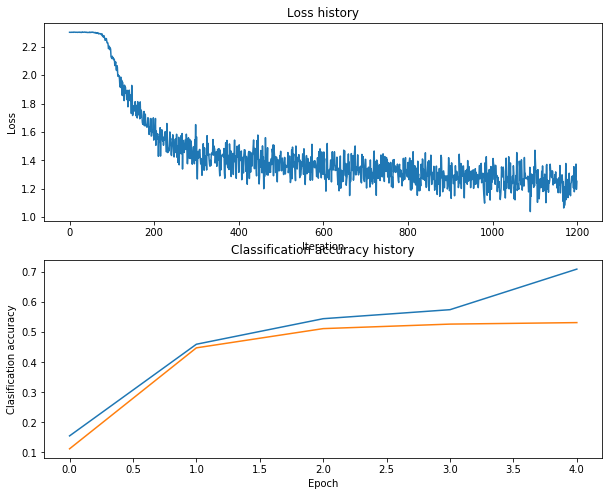

reg:  0.001
iteration 0 / 1200: loss 2.302586
iteration 100 / 1200: loss 2.130747
iteration 200 / 1200: loss 1.595028
iteration 300 / 1200: loss 1.542322
iteration 400 / 1200: loss 1.305486
iteration 500 / 1200: loss 1.341420
iteration 600 / 1200: loss 1.329719
iteration 700 / 1200: loss 1.315019
iteration 800 / 1200: loss 1.177863
iteration 900 / 1200: loss 1.387880
iteration 1000 / 1200: loss 1.234898
iteration 1100 / 1200: loss 1.331981


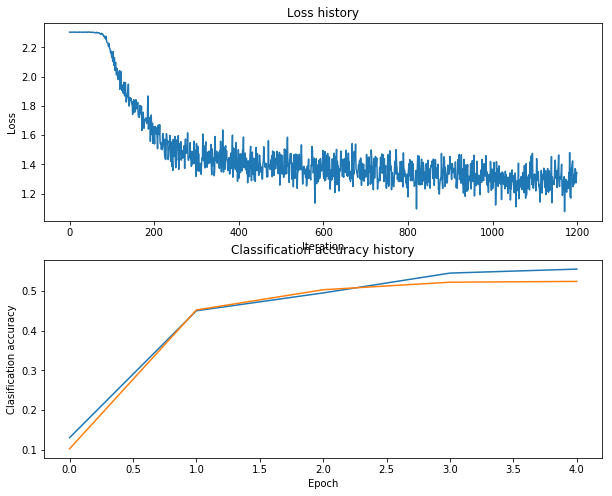

learning:  0.3
reg:  0.0005
iteration 0 / 1200: loss 2.302586
iteration 100 / 1200: loss 1.760567
iteration 200 / 1200: loss 1.367418
iteration 300 / 1200: loss 1.408214
iteration 400 / 1200: loss 1.295996
iteration 500 / 1200: loss 1.285062
iteration 600 / 1200: loss 1.225087
iteration 700 / 1200: loss 1.189065
iteration 800 / 1200: loss 1.313224
iteration 900 / 1200: loss 1.252515
iteration 1000 / 1200: loss 1.276671
iteration 1100 / 1200: loss 1.051662


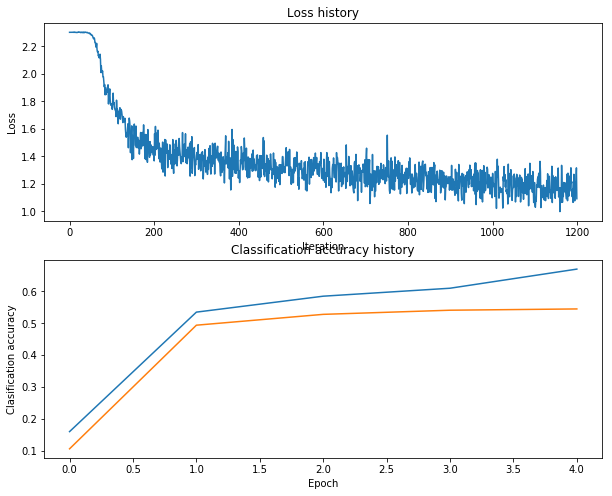

reg:  0.001
iteration 0 / 1200: loss 2.302586
iteration 100 / 1200: loss 1.829317
iteration 200 / 1200: loss 1.374978
iteration 300 / 1200: loss 1.372994
iteration 400 / 1200: loss 1.247994
iteration 500 / 1200: loss 1.291218
iteration 600 / 1200: loss 1.379834
iteration 700 / 1200: loss 1.432419
iteration 800 / 1200: loss 1.250521
iteration 900 / 1200: loss 1.343784
iteration 1000 / 1200: loss 1.247016
iteration 1100 / 1200: loss 1.236755


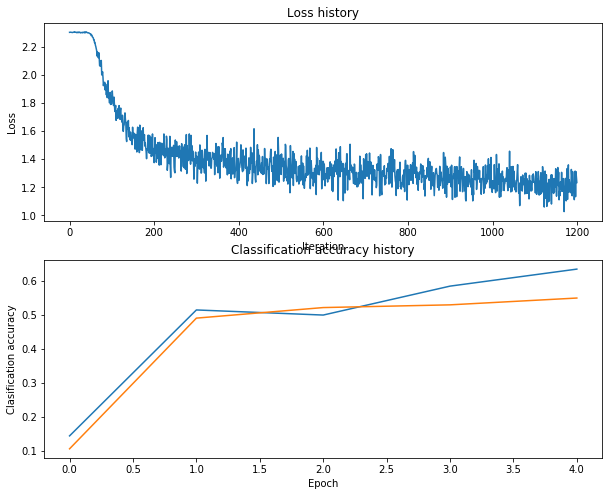

In [96]:
from cs175.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
batch_size = [200]
learning_rates = [1e-1, 2e-1, 3e-1]
regularization_strengths = [5e-4, 1e-3,]
hidden_size = [500]
best_acc = -1
for hid in hidden_size:
    print("hidden: ", hid)
    for bs in batch_size:
        print("batch: ", bs)
        for learn in learning_rates:
            print("learning: ", learn)
            for reg in regularization_strengths:
                print("reg: ", reg)
                net = TwoLayerNet(input_dim, hid, num_classes)
                stats = net.train(X_train_feats,y_train,X_val_feats,y_val,num_iters=1200,batch_size=bs,
                                  learning_rate=learn,reg=reg,verbose=True)
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                if val_acc > best_acc:
                    best_net = net
                    best_acc = val_acc
                    best_stats = stats

                # Plot the loss function and train / validation accuracies
                plt.subplot(2, 1, 1)
                plt.plot(stats['loss_history'])
                plt.title('Loss history')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')

                plt.subplot(2, 1, 2)
                plt.plot(stats['train_acc_history'], label='train')
                plt.plot(stats['val_acc_history'], label='val')
                plt.title('Classification accuracy history')
                plt.xlabel('Epoch')
                plt.ylabel('Clasification accuracy')
                plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [99]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.559


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!